In [1]:
%store -r after_scaler
%store -r out

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras import layers, Sequential
from tensorflow import feature_column

In [3]:
df = out.copy()
df.rename(columns = {'Gender':'gender',	
                     'Age':'age', 
                     'Birth Weight':'birth_weight',
                     'Birth Length' : 'birth_length', 
                     'Body Weight' : 'body_weight', 
                     'Body Length' : 'body_length', 
                     'Breastfeeding':'breastfeeding'},
                     inplace = True)

df.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,breastfeeding,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,2,2,20.230474
1,1,16,2.9,49,66.5,156.2,2,1,42.573624
2,2,11,2.8,49,66.5,185.0,2,2,35.945946
3,2,17,2.8,49,78.1,193.0,2,1,40.466321
4,2,10,2.7,49,68.8,151.0,2,2,45.562914


In [4]:
#change binary value and drop useless feature
df.gender[df['gender'] == 2] = 0
df.Stunting[df['Stunting'] == 2] = 0
df.BMI = round(df.BMI, 2)
df.drop('breastfeeding', axis=1, inplace=True)
df.head(1)

C:\Users\fadil\AppData\Local\Temp\ipykernel_22768\876021827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.gender[df['gender'] == 2] = 0
C:\Users\fadil\AppData\Local\Temp\ipykernel_22768\876021827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Stunting[df['Stunting'] == 2] = 0


,gender,age,birth_weight,birth_length,body_weight,body_length,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,0,20.23


In [5]:
#split labels and feature
df_feat = df[['gender', 'age', 'birth_weight', 'birth_length', 'body_weight', 'body_length', 'BMI']]
labels = df['Stunting']

#scalling
scaler = StandardScaler()
df_standard = scaler.fit_transform(df_feat)

#label encode
encoder = LabelEncoder()
encoder.fit(labels)
y_encoder = encoder.transform(labels)

In [6]:
#labels y
X_train, X_test, y_train, y_test = train_test_split(df_standard, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_val.shape

#dosen't separate label
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

(872, 7)

In [7]:
print(len(X_train), len(y_train))
print(len(X_test))
print(len(X_val))

3488 3488
1091
872


In [8]:
#imbalance, if need only
zeros = df[df['Stunting'] == 0]
ones = df[df['Stunting'] == 1]

zero_num = zeros['Stunting'].to_numpy()
one_num = ones['Stunting'].to_numpy()
zero_one = np.concatenate((zero_num, one_num))
unique = np.unique(zero_one)

mass = compute_class_weight(class_weight='balanced', classes=unique, y=zero_one)
weight = dict(zip(np.unique(zero_one), mass))

In [9]:
#, kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [31]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

model = keras.Sequential([
    layers.Dense(2048, input_shape=(X_train.shape[-1],)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(1024),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.4),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
log = model.fit(X_train, y_train, 
                validation_data=(X_val, y_val),
                  epochs=260, 
                  verbose=1,
                  batch_size=20)

Epoch 1/300
175/175 [==============================] - 5s 22ms/step - loss: 0.9553 - accuracy: 0.4828 - val_loss: 0.6750 - val_accuracy: 0.6296
Epoch 2/300
175/175 [==============================] - 4s 21ms/step - loss: 0.8335 - accuracy: 0.5530 - val_loss: 0.6097 - val_accuracy: 0.7534
Epoch 3/300
175/175 [==============================] - 5s 27ms/step - loss: 0.7476 - accuracy: 0.5906 - val_loss: 0.5802 - val_accuracy: 0.7534
Epoch 4/300
175/175 [==============================] - 5s 28ms/step - loss: 0.6832 - accuracy: 0.6411 - val_loss: 0.5714 - val_accuracy: 0.7523
Epoch 5/300
175/175 [==============================] - 5s 27ms/step - loss: 0.6438 - accuracy: 0.6775 - val_loss: 0.5453 - val_accuracy: 0.7592
Epoch 6/300
175/175 [==============================] - 5s 28ms/step - loss: 0.6018 - accuracy: 0.7136 - val_loss: 0.5188 - val_accuracy: 0.7764
Epoch 7/300
175/175 [==============================] - 5s 26ms/step - loss: 0.5861 - accuracy: 0.7311 - val_loss: 0.5044 - val_accuracy:

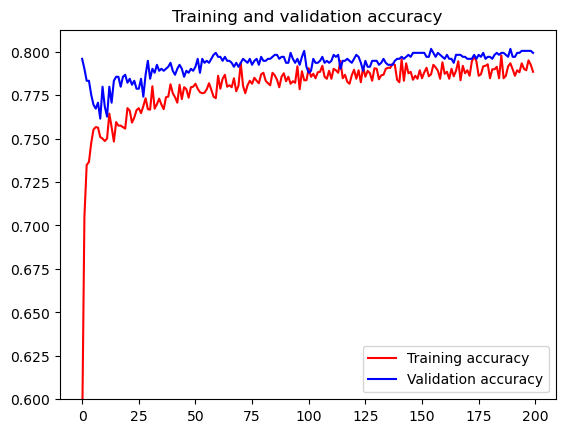

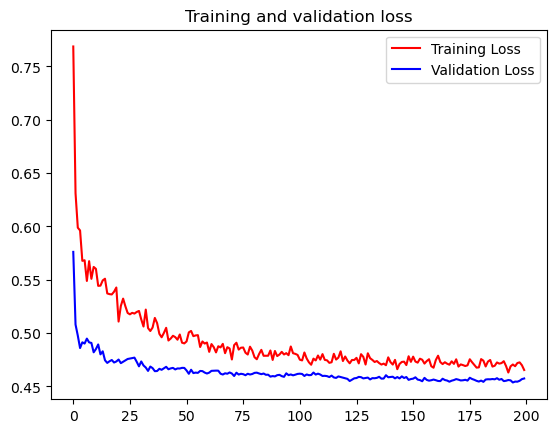

In [11]:
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim(0.6)
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4457
Test Accuracy: 0.8112


35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.60      0.34      0.43       231
           1       0.84      0.94      0.89       860

    accuracy                           0.81      1091
   macro avg       0.72      0.64      0.66      1091
weighted avg       0.79      0.81      0.79      1091



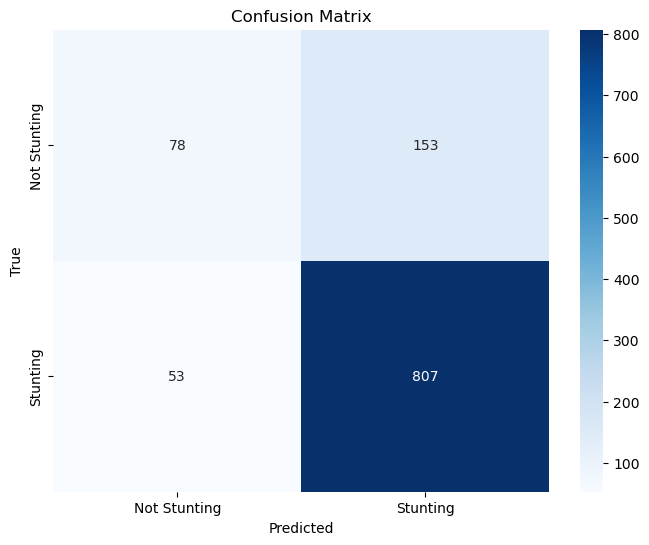

In [13]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = ['Not Stunting', 'Stunting']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
model.save('./model/stunting_model.h5')
convert = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = convert.convert()

with open('./model/stunting_model.tflite', 'wb') as f:
    f.write(tflite)

INFO:tensorflow:Assets written to: C:\Users\fadil\AppData\Local\Temp\tmp0zfxiycw\assets


# Hypertune

In [15]:
def build_model(hp):
        model = Sequential()
        model.add(
                layers.Dense(units=hp.Int("units_", min_value=64, max_value=128, step=32), activation="relu")
        )
        for i in range(1, hp.Int("num_layers", 2,5)):
                model.add(
                        layers.Dense(units=hp.Int("units_" + str(i), min_value=6, max_value=512, step=32), activation="relu")
                )
                
        model.add(
                layers.Dense(units=1, activation="sigmoid")
        )

        lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      metrics=["accuracy"]
                      )     
        
        return model

In [16]:
#DELETE HYPER TUNING FOLDER FIRST, default name untitled_project
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=80,
    factor=3,
    hyperband_iterations=10
)

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_ (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(X_train, y_train, 
             validation_data=(X_val, y_val), 
             epochs=100, 
             callbacks=[stop_early], 
             verbose=2)

Trial 48 Complete [00h 00m 02s]
val_accuracy: 0.8073394298553467

Best val_accuracy So Far: 0.8142201900482178
Total elapsed time: 00h 01m 04s

Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
96                |64                |units_
4                 |2                 |num_layers
102               |38                |units_1
0.01              |0.01              |learning_rate
262               |358               |units_2
294               |454               |units_3
294               |166               |units_4
27                |9                 |tuner/epochs
9                 |3                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |1                 |tuner/round
0034              |0019              |tuner/trial_id

Epoch 10/27
109/109 - 1s - loss: 0.4839 - accuracy: 0.7792 - val_loss: 0.4597 - val_accuracy: 0.8073 - 719ms/epoch - 7ms/step
Epoch 11/27
109/109 - 0s - loss: 0.4730 - accuracy: 0.7

KeyboardInterrupt: 

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[stop_early], verbose=2)